In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

### Representation of urdf file

To help with debugging I wrote some functions that read the simplified urdf file that defines Kuka arm Kr210. This will help with visualizing the difference in representation between Denavit–Hartenberg and urdf.
First let's write a function to draw three arrows in 3d space representing a local frame of reference.

In [2]:
def add_frame(axes, origin, x1, x2, rep='XZ'):
    """
    Takes an matplotlib 3d axes and adds a triplet of arroys representing origin coordinates
    The frame of reference can be passed defined with two vectors representing x and z unit vectors,
    xy unit vectors or yz unit vectors. The third component is calculated"""
    org = np.vstack((origin, origin, origin))
    if rep == 'XZ':
        x = np.array(x1)
        z = np.array(x2)
        y = np.cross(x2, x1)
    elif rep == 'XY':
        x = np.array(x1)
        y = np.array(x2)
        z = np.cross(x1, x2)
    elif rep== 'YZ':
        y = np.array(x1)
        z = np.array(x2)
        x = np.cross(x1, x2)
    else:
        print('representation not valid')
    arrows = np.vstack((x,y,z))
    for arrow, color in zip(arrows, ['r','g','b']):
        # Length hardcoded for this problem. Assuming m as dimensions
        axes.quiver3D(org[0, 0], org[0, 1], org[0, 2], arrow[0], arrow[1], arrow[2],
                      length=0.3, color=color, normalize=True)
    

In [3]:
import xml.etree.ElementTree as ET
with open('./simplified_kr210.urdf') as urdf_file:
    urdf = ET.parse(urdf_file)

In [4]:
rev_joints = []
# append one representing the origin
rev_joints.append((np.array([0.0,0.0,0.0]), np.array([0.0,0.0,1.0])))
for joint in urdf.findall("joint/[@type='revolute']"):
    origin = joint.find('origin').attrib['xyz']
    axis = joint.find('axis').attrib['xyz']
    o = np.fromstring(origin, sep=' ')
    a = np.fromstring(axis, sep=' ')
    rev_joints.append((o, a))

<IPython.core.display.Javascript object>


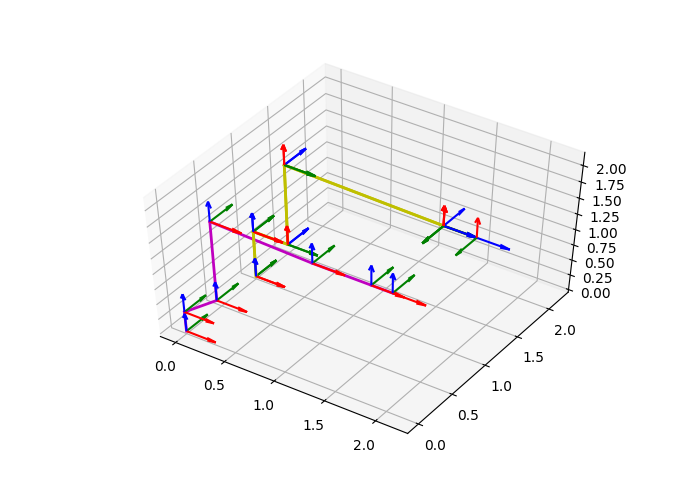

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pos = np.array([0.0,0.0,0.0])
max_coord = 0.0
for joint in rev_joints:
    base = np.array(pos)
    pos += joint[0]
    ax.plot((base[0], pos[0]), (base[1], pos[1]), linewidth=2, zs=(base[2], pos[2]), color='m')
    max_coord = max(max_coord, pos.max())
    add_frame(ax, pos, [1,0,0], [0,0,1])
ax.auto_scale_xyz([0,max_coord], [0,max_coord], Z=[0,max_coord])
fig.set_size_inches(7,5)

Here I ploted the joints in 3d to get an idea of what the frames look like

### Symbolic Forward Kinematics

Let's now try to get the forward kinematics in symbolic form. It is useful to build a 3d view of the frames, but this time as interpreted in DH configuration. Therefore, we first define the robot following the convention:

In [6]:
from sympy import symbols, cos, sin, pi, simplify, atan2, init_printing
from sympy.matrices import Matrix
init_printing()

# working with lists would make it easier latter on
q_s = symbols('q1:8')
d_s = symbols('d1:8')
a_s = symbols('a0:7')
alpha_s = symbols('alpha0:7')

alpha = [0.0, -pi/2, 0.0, -pi/2, pi/2, -pi/2, 0.0]
a = [0.0, 0.35, 1.25, -0.054, 0.0, 0.0, 0.0]
d = [0.75, 0.0, 0.0, 1.5, 0.0, 0.0, 0.303]
q = list(q_s)
q[1] = q_s[1] - pi/2
q[6] = 0.0
dh = dict(zip(a_s, a))
dh.update(dict(zip(alpha_s, alpha)))
dh.update(dict(zip(d_s, d)))
dh.update(dict(zip(q_s, q)))
# DH table
dh

A function to calculate the each transformation matrix is very useful here:

In [7]:
def transform(alpha, a, d, q):
    """
    Helper function. given the values for a tranformation between two joints it returns
    the tranformtion matrix
    """
    T = Matrix([[cos(q), -sin(q), 0.0, a],
                [sin(q) * cos(alpha), cos(q) * cos(alpha), -sin(alpha), -sin(alpha) * d],
                [sin(q) * sin(alpha), cos(q) * sin(alpha),  cos(alpha),  cos(alpha) * d],
                [0.0, 0.0, 0.0, 1.0]])
    return T

In [8]:
# list of transformations
T_s = []
for alpha, a, d, q in zip(alpha_s, a_s, d_s, q_s):
    T_s.append(transform(alpha, a, d, q).subs(dh))

Let's put numeric values into the transformations and plot then side by side with the frames of the urdf file. I just added an offset to global coordinate y to help with the comparison.

<IPython.core.display.Javascript object>


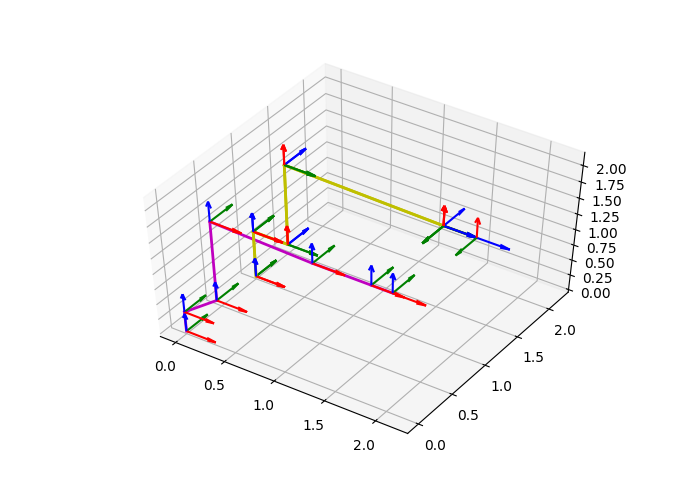

In [16]:
# base frame of reference:
pos = Matrix([0.0, 0.0, 0.0, 1.0])
x1 = Matrix([1.0, 0.0, 0.0])
x2 = Matrix([0.0, 0.0, 1.0])
# selected configuration
conf = dict(zip(q_s, [0.0] * len(q_s)))
max_coord = 0.0
origin = Matrix([0.0, 1.0, 0.0, 1.0])
add_frame(ax, origin[0:3], x1[:3], x2[:3])


# total transformation:
T = Matrix.eye(4)
joint_id = 1
for t in T_s:
    T *= t
    base = np.array(origin[:3])
    origin = (T * pos).subs(conf)
    origin[1] = 1.0
    x = T[:3, :3].subs(conf) * x1
    z = T[:3, :3].subs(conf) * x2
    # print('Joint {:d} x axis in global coords:'.format(joint_id), x1[:3])
    # print('Joint {:d} z axis in global coords:'.format(joint_id), x2[:3])
    max_coord = max(max_coord, max(origin))
    ax.plot((base[0], origin[0]), (base[1], origin[1]), linewidth=2, zs=(base[2], origin[2]), color='y')
    add_frame(ax, origin[:3], x[:3], z[:3])
    joint_id += 1
    
ax.auto_scale_xyz([0,max_coord], [0,max_coord], Z=[0,max_coord])
fig

### Correction of end effector

The final frame of reference needs to be rotated to match what is in the urdf file. To position it correctly, we need to rotate it -pi/2 around the y axis and pi around the z axis. For those operations let's buils generic rotation matrices:

In [27]:
theta1, theta2, theta3 = symbols('theta1:4')
R_x = Matrix([[ 1, 0, 0],
              [ 0, cos(theta1), -sin(theta1)],
              [ 0, sin(theta1),  cos(theta1)]])
R_y = Matrix([[ cos(theta2), 0, sin(theta2)],
              [ 0, 1, 0],
              [-sin(theta2), 0,  cos(theta2)]])
R_z = Matrix([[ cos(theta3), -sin(theta3), 0],
              [ sin(theta3),  cos(theta3), 0],
              [ 0, 0, 1]])

In [29]:
# Correction matrix
corr = (R_z.subs(theta3, pi) * R_y.subs(theta2, -pi/2))

In [30]:
T.subs(conf)[:3, :3] * corr

⎡1  0  0⎤
⎢       ⎥
⎢0  1  0⎥
⎢       ⎥
⎣0  0  1⎦

In [13]:
T_s[2]

⎡cos(q₃)  -sin(q₃)  0.0  1.25⎤
⎢                            ⎥
⎢sin(q₃)  cos(q₃)    0    0  ⎥
⎢                            ⎥
⎢   0        0       1   0.0 ⎥
⎢                            ⎥
⎣  0.0      0.0     0.0  1.0 ⎦

In [14]:
theta1, theta2, theta3 = symbols('theta1:4')

In [15]:
R_x

⎡1     0        0    ⎤
⎢                    ⎥
⎢0  cos(θ₁)  -sin(θ₁)⎥
⎢                    ⎥
⎣0  sin(θ₁)  cos(θ₁) ⎦